# ACSE-3 (Numerical Methods) <a class="tocSkip">

## Coursework<a class="tocSkip">

# Instructions  <a class="tocSkip">
    

- This is the assessed coursework for module ACSE-3: Numerical Methods for year 2019/20.


- This is independent work, you cannot work in groups.


- Each question below is equally weighted in terms of marks.


- You will be assessed on both your code as well as your supporting descriptions/discussions of the results you obtain.


- You may use NumPy and SciPy. If you use an algorithm (e.g. from SciPy) not explicitly mentioned in the question, then please explain which algorithm you are using and why you have chosen it.


- You should submit your solutions as a single self-contained Jupyter notebooks via Github classroom - please submit a version where you have run all of the cells and all the outputs/plots etc are visible without me having to run the notebook myself.


<br><br>

# DEADLINE:   5pm Sunday 5 Jan 2020 <a class="tocSkip">

<br><br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coursework-Q1---Implement-RK2-family" data-toc-modified-id="Coursework-Q1---Implement-RK2-family-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coursework Q1 - Implement RK2 family</a></span></li><li><span><a href="#Coursework-Q2---Implementing-backward-Euler-using-a-nonlinear-system-solver" data-toc-modified-id="Coursework-Q2---Implementing-backward-Euler-using-a-nonlinear-system-solver-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Coursework Q2 - Implementing backward Euler using a nonlinear system solver</a></span></li><li><span><a href="#Coursework-Q3---Steady-state-advection-diffusion-with-the-FEM" data-toc-modified-id="Coursework-Q3---Steady-state-advection-diffusion-with-the-FEM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Coursework Q3 - Steady-state advection-diffusion with the FEM</a></span></li><li><span><a href="#Coursework-Q4---Time-dependent-advection-diffusion-with-the-FEM" data-toc-modified-id="Coursework-Q4---Time-dependent-advection-diffusion-with-the-FEM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Coursework Q4 - Time-dependent advection-diffusion with the FEM</a></span></li></ul></div>

In [108]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Coursework Q1 - Implement RK2 family

Write a function that implements the RK2 family of methods which takes in the free parameter $\alpha$ that appears in the most general definition of RK2.

For example the first line of your function might read

```Python
def RK2_alpha(f, y0, t0, t_max, dt, alpha=0.5):
```

where `f` is a function of time and the solution $y$.

<br>

Perform some verification tests of your function to confirm that with the choice $\alpha=1$ your implementation agrees with results from the improved Euler method which was implemented in lecture 5. 

<br>

Test for convergence using several different values of $\alpha$ using the test problem with RHS and exact solutions given by the test case we saw in lecture 6:

$$ y' = y + t^3, \;\;\;\;\;\; y(0) = 1, $$  

which has the exact solution

$$ y(t) = 7\text{e}^t - t^3 - 3t^2 - 6t - 6. $$

You may make use of the following functions implementing these:

```python
def f(t, y):
    return y + t**3

def y_ex(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6
```

<br>

Consider a simple error metric given by the error in the solution at time $t=3$.

<br>

Plot your convergence results, compared with results from the forward Euler and the improved Euler methods, and add to the graph your estimates for the order of convergence of each method.

<br>

Also, for a fixed time step size, compute and plot how the error varies as a function of $\alpha$ for values in the range $[0.1,4.0]$.  

<br>

What is the optimal value of $\alpha$ which minimises the error for this problem?

In [109]:
def RK2_alpha(f, y0, t0, t_max, dt, alpha=0.5):
    """
     f: input function of t and solution of y
    """
    
    u = np.array(u0) #array intialized to hold mesh points t
    tau = np.array(t0) #array to hold Midpoint
    u_all = [u0]
    tau_all = [t0]  #intial condition
    
    #iterative method
    while tau < t_max:
        k1 = f(tau, u)
        # next iteration using midpoint method 
        u = u + dt * ( (1-1/(2*alpha))*k1 + 1/(2*alpha)* f(tau + alpha*dt, u + alpha*dt*k1 ))
        u_all.append(u)
        tau = tau + dt
        tau_all.append(tau)
    
    return np.array(tau_all), np.array(u_all)


Perform some verification tests of your function to confirm that with the choice 𝛼=1 
your implementation agrees with results from the improved Euler method which was implemented in lecture 5.

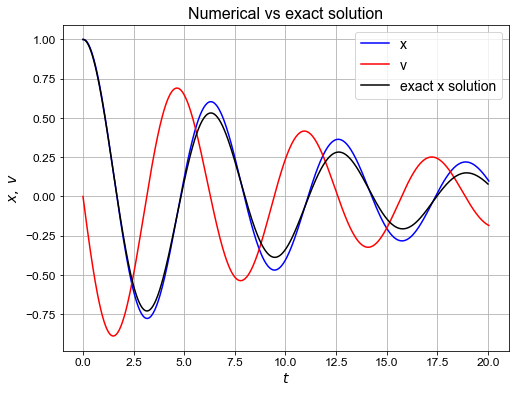

In [121]:
# Let's 
# numerical parameters for problem
om0 = 1
zeta = 0.1
# initial data (we need two for this coupled problem)
x0 = 1
v0 = 0
# simulation period and time step size
t0 = 0.
tf = 20.
dt = 0.04

# initial condition
u0 = np.array([x0, v0])
uall, tall = forward_euler(f_msd, u0, t0, tf, dt)

# pull out the individual solution vectors (don't need to do this)
x = uall[:, 0]
v = uall[:, 1]

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
ax1.plot(tall, x, 'b', label='x')
ax1.plot(tall, v, 'r', label='v')
ax1.set_xlabel(r'$t$', fontsize=14)
ax1.set_ylabel(r'$x,\; v$', fontsize=14)
ax1.set_title('Numerical vs exact solution', fontsize=16)
ax1.grid(True)

def x_exact(t):
    # the exact solution to the x component of the problem
    om = om0 * np.sqrt(1-zeta**2)
    x_exact = (np.exp(-zeta*om0*t)*(x0*np.cos(om*t) +
                                    (zeta*x0+v0/om0)*((om0/om)**2)*np.sin(om*t)))
    return x_exact

tfine = np.arange(0, tf, dt/100)
ax1.plot(tfine, x_exact(tfine), 'k', label='exact x solution')
# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax1.legend(loc='best', fontsize=14);

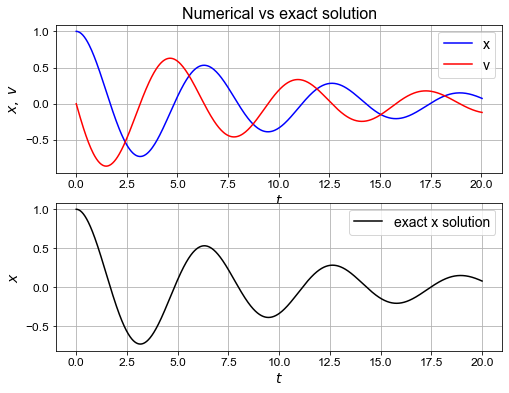

In [122]:
## RK2
tall,uall = RK2_alpha(f_msd, u0, t0, tf, dt, 1)

# pull out the individual solution vectors (don't need to do this)
x = uall[:,0]
v = uall[:,1]

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax1.plot(tall, x, 'b', label='x')
ax1.plot(tall, v, 'r', label='v')
ax1.set_xlabel(r'$t$', fontsize=14)
ax1.set_ylabel(r'$x,\; v$', fontsize=14)
ax1.set_title('Numerical vs exact solution', fontsize=16)
ax1.grid(True)
# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax1.legend(loc='best', fontsize=14);

ax2 = plt.subplot(212)
tfine = np.arange(0, tf, dt/100)
ax2.plot(tfine, x_exact(tfine), 'k', label='exact x solution')
ax2.set_xlabel(r'$t$', fontsize=14)
ax2.set_ylabel(r'$x$', fontsize=14)
ax2.grid(True)

# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax2.legend(loc='best', fontsize=14);

Test for convergence using several different values of 𝛼 using the test problem with RHS 
and exact solutions given by the test case we saw in lecture 6:
Consider a simple error metric given by the error in the solution at time 𝑡=3 
Plot your convergence results, compared with results from the forward Euler and the improved Euler methods, 
and add to the graph your estimates for the order of convergence of each method.

In [123]:
def f(t, y):
    return y + t**3

def y_ex(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6

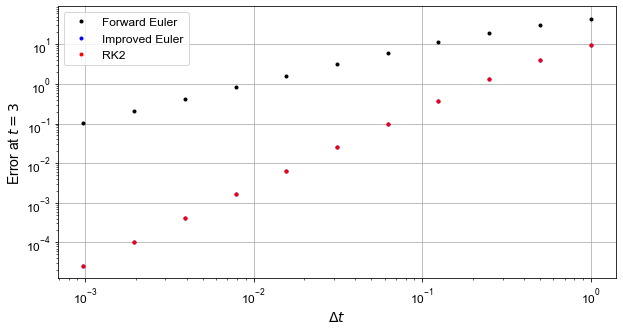

In [124]:
def forward_euler(f, u0, t0, t_max, dt):
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        u = u + dt*f(t, u)  # euler guess
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

def improved_euler(f, u0, t0, t_max, dt):
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        ue = u + dt*f(t, u)  # euler guess
        u = u + 0.5*dt* ( f(t, u) + f(t + dt, ue) )
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

# problem parameters
dt = 0.04
u0 = 1.0
t0 = 0.0
tf = 2*np.pi

def approx_error(dt, t_max):
    uall, tall = forward_euler(f, u0, t0, t_max, dt)
    err1 = abs(uall[-1] - y_ex(t_max))
    uall, tall = improved_euler(f, u0, t0, t_max, dt)
    err2 = abs(uall[-1] - y_ex(t_max))
    tall,uall = RK2_alpha(f, u0, t0, t_max, dt, 1)
    err3 = abs(uall[-1] - y_ex(t_max))
    return err1, err2, err3

error_fe = []
error_ie = []
error_rk2 = []
dt_array = []
dt = 1.
while dt > 5.e-4:
    dt_array.append(dt)
    err1, err2, err3 = approx_error(dt, 3)
    error_fe.append(err1)
    error_ie.append(err2)
    error_rk2.append(err3)
    dt *= 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.loglog(dt_array, error_fe, 'k.', label='Forward Euler')
ax1.loglog(dt_array, error_ie, 'b.', label='Improved Euler')
ax1.loglog(dt_array, error_rk2, 'r.', label='RK2')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.grid(True)
ax1.legend()
# use numpy.polyfit to find best fit linear line to data

Also, for a fixed time step size, compute and plot how the error varies as a function of 𝛼　for values in the range [0.1,4.0] 
What is the optimal value of 𝛼, which minimises the error for this problem?

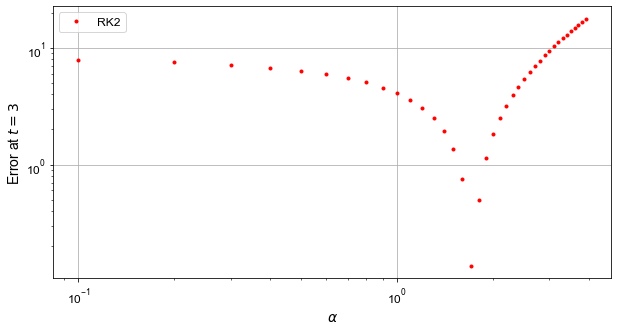

In [139]:
alphas = np.arange(0.1, 4, 0.1)
dt = 0.5 # fixed 
t_max = 3
error_rk2 = []
for alpha in alphas:
    tall,uall = RK2_alpha(f, u0, t0, t_max, dt, alpha)
    err3 = abs(uall[-1] - y_ex(t_max))
    error_rk2.append(err3)
    
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.loglog(alphas, error_rk2, 'r.', label='RK2')
ax1.set_xlabel('$\\alpha$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.grid(True)
ax1.legend()

# Coursework Q2 - Implementing backward Euler using a nonlinear system solver

In the lecture 5 homework (question "circular orbits") we considered the vector ODE problem

\begin{align*}
\dot{x} & = -y, \\[5pt] 
\dot{y} & = x
\end{align*} 

with initial conditions $x(0)=1,\; y(0)=0$.  

We saw in that homework question how the forward and improved Euler methods performed on this problem.

Recall that the exact solution's trajectory in $(x,y)$ space should map out a circle, but forward Euler's orbit was found to rapidly increase in diameter.

<br> 

Write a function to implement the backward Euler scheme for a generic RHS vector function $\boldsymbol{f}$. 

To do this you will need to call a nonlinear system solver, make use of one of the ones that we saw in lecture 4.

<br>

Run your code for the above problem and comment on the qualitative differences between your solution obtained with backward Euler with that obtained using forward Euler.

<br>

Based on your observations implement another implicit two-level scheme which should provide qualitatively improved results compared with both forward and backward Euler. 

<br>

Given that the exact solution maps out a circle, consider what mathematical conservation law (a function of the solution variables that should be constant) the solution should respect and check how well each of your methods performs at satisfying this law.

# Coursework Q3 - Steady-state advection-diffusion with the FEM


In this part of the question we want to solve steady-state advection-diffusion using the (non-local-assembly based) finite element approach we developed in lecture 11.



Using the finite element method
formulate and solve the steady-state advection-diffusion (boundary value) problem with Dirichlet boundary conditions we considered in lecture 7 (the exact solution to which is given below).

The difference to what we've seen before in our FEM codes is that you now need to discretise the advection term, which ultimately involves integrating basis functions multiplied by their derivatives over elements.

[**Hint:** *your starting point for this might be the code we wrote in lecture 11 section 5.4 ("Dealing with more complex BCs (Inhomogeneous Dirichlet)"). You need to add in an extra contribution to the LHS corresponding to advection (cf. L11 homework 1.4 where we ended up adding a mass matrix when we solved the problem $u''+u=f$).  You will need to remember to also add in the appropriate extra advection related RHS terms corresponding to the boundary contributions (as was explained in the context of diffusion in section 5.4.2 of lecture 11).*]

<br>

Verify your implementation with a convergence with $\Delta x$ analysis using the exact solution given by
```Python
def u_exact(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)
```
You can use the following parameters (using the notation of lecture 7)
```Python
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1
```
where `CE` is the Dirichlet BC value at the right hand boundary, the left hand boundary being a homogeneous Dirichlet condition.



<br>

Do you observe the expected order of convergence?

<br>

Finally, compare the errors in your solution against a corresponding finite difference solver. You may re-use code from lecture 7 for this. What do you observe?

<br>

Throughout this question you may assume for simplicity a uniform mesh.

# Coursework Q4 - Time-dependent advection-diffusion with the FEM

In this part of the question we want to solve unsteady advection-diffusion.

This time base your solution on the 1D (local) assembly based finite element solver we implemented in lecture 12 and generalise it to include advection.

Test your implementation using the same advection-diffusion of a Gaussian problem considered in
lecture 8 homework question 2 "An analytical solution to advection-diffusion" where I explained and demonstrated how an appropriate Gaussian function can be considered as an exact solution to the advection-diffusion problem as long as we initialise our solution with the Gaussian evaluated at some $t>0$  (since in the limit of  $t=0$   the solution is a Dirac-delta function), and use that same offset in time for the purpose of comparing the analytical solution with the numerical solution you obtain.


```python
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analtical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)
```


We can then use the same function evaluated at the appropriate time as an exact solution to compare our numerical method against.
For this question you can consider the (non-periodic) domain $x\in[0,3]$ and you can assume homogeneous Neumann boundary conditions. Initialise the problem using the analytical solution centred initially at $x=0.5$ with an initial time for the purposes of evaluating the Gaussian function of $t=0.05$. Assume a velocity of 1 and a diffusivity of 0.01. Integrate the problem for a total time period of 1 [NB. I've purposefully set these values and the size of the domain so you don't need to worry about your Gaussian getting close to a boundary].

Perform some experiments with different $\Delta x$ and $\Delta t$ values such that you can demonstrate the expected order of convergence in space and in time (for the time-stepping options of forward Euler, backward Euler and Crank-Nicolson). To do this I suggest you fix one of $\Delta x$ or $\Delta t$ and vary the other independently.